#  Crop Disease Detection 

###  Project Summary

In this project, we aim to build a machine learning model that can detect **crop diseases** based on leaf data using the PlantVillage dataset. Early detection of plant diseases is crucial to protecting food security, reducing yield loss, and helping farmers take timely action.

We'll use structured data or image-based data to **classify whether a plant is healthy or infected**, and if infected, determine the specific disease.

---

###  Problem Statement

Farmers often struggle to diagnose plant diseases due to limited access to experts or technology. Automating disease detection can:

- Help farmers **identify diseases early**
- Reduce crop loss
- Improve treatment decision-making
- Enable **mobile-based advisory tools**

Our goal is to develop a **supervised learning model** that can predict the type of disease affecting a plant leaf, using the provided features (image or tabular).

---

###  Project Objectives

1. Load and explore the PlantVillage dataset
2. Clean and preprocess the data
3. Train classification models to detect crop diseases
4. Evaluate model performance using appropriate metrics
5. Use model interpretability tools to explain predictions
6. Provide recommendations based on prediction results

---

###  Dataset Overview

We will use the [PlantVillage dataset](https://www.kaggle.com/datasets/emmarex/plantdisease), which includes:

- **Images** or structured features of plant leaves
- Labels like `"Tomato___Late_blight"`, `"Apple___Black_rot"`, etc.
- Data for multiple crop types and disease classes

The dataset supports both **image classification** and **structured learning**, depending on the format.

---

###  Tools and Technologies

- Python 
- Pandas, NumPy for data handling
- Scikit-learn for modeling
- Matplotlib & Seaborn for visualization
- TensorFlow/Keras for image classification
- SHAP/LIME for model explainability

---

###  Target Audience

This model can benefit:
- Farmers using digital advisory tools
- Agritech companies building mobile apps
- Agricultural researchers and extension officers


---

##  Step 1: Load and Prepare Image Data for Modeling

We are using the image folder version of the PlantVillage dataset. In this step, we'll:

- Load images from directories using Keras
- Automatically assign labels based on folder names (e.g. `Tomato___Early_blight`)
- Resize and normalize image pixels
- Split data into training and validation sets

The images will be rescaled to have pixel values between 0 and 1, and resized to 128x128 for faster training.

---


In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
dataset_path = r'C:\Users\USER\Documents\Flatiron\Phase 4 project\Crop-Disease-Detection\PlantVillage'

# Set image parameters
img_size = (128, 128)
batch_size = 32

# Create ImageDataGenerator for training and validation
datagen = ImageDataGenerator(
    # Normalize pixel values
    rescale=1./255,   
    # 80/20 train/val split        
    validation_split=0.2       
)

# Load training images
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation images
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 33027 images belonging to 16 classes.
Found 8249 images belonging to 16 classes.


##  Step 2: Data Cleaning and Exploratory Data Analysis (EDA)

Even with image data, it's important to explore and understand the dataset before modeling.

We'll:
- Visualize the class distribution
- Preview sample images per disease
- Confirm image shape and rescaling
- Ensure labels match image folders

---

### **2.1 Check Class Distribution**

It's important to understand how balanced or imbalanced the dataset is across different disease categories.

If certain classes have significantly more or fewer images, the model may become biased, learning to favor more common diseases while ignoring rare ones.

We use the `train_generator` from Keras to extract the class labels and visualize the number of training images per class.

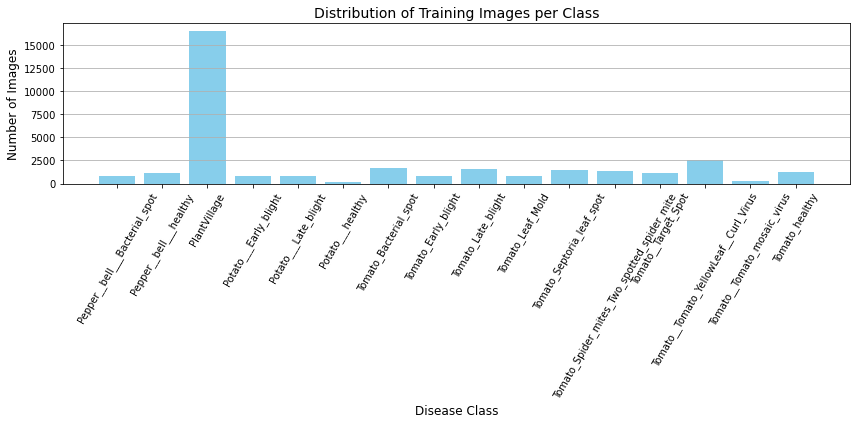

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Extract class labels and counts
class_labels = list(train_generator.class_indices.keys())
class_counts = [np.sum(train_generator.classes == i) for i in range(len(class_labels))]

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(class_labels, class_counts, color='skyblue')
plt.title("Distribution of Training Images per Class", fontsize=14)
plt.xlabel("Disease Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=60)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The chart above shows the number of training images per class in the PlantVillage dataset.

We observe a significant **class imbalance**, with one class (`PlantVillage`) dominating the dataset, possibly due to a mislabel or directory issue.

Imbalance like this can lead to biased model predictions. We may address it using:
- Class weights
- Data augmentation
- Folder restructuring if needed

This insight helps guide better modeling decisions.

---

### **2.2Visualizing Sample Images by Class**

As part of our image dataset EDA, it's important to visually inspect a few examples from different classes. This allows us to:

- Verify that labels are accurate and images are clear
- Understand intra-class variability (how similar images of the same class are)
- Understand inter-class differences (how distinct the classes look visually)

Below we show randomly selected samples from the training set across multiple classes.

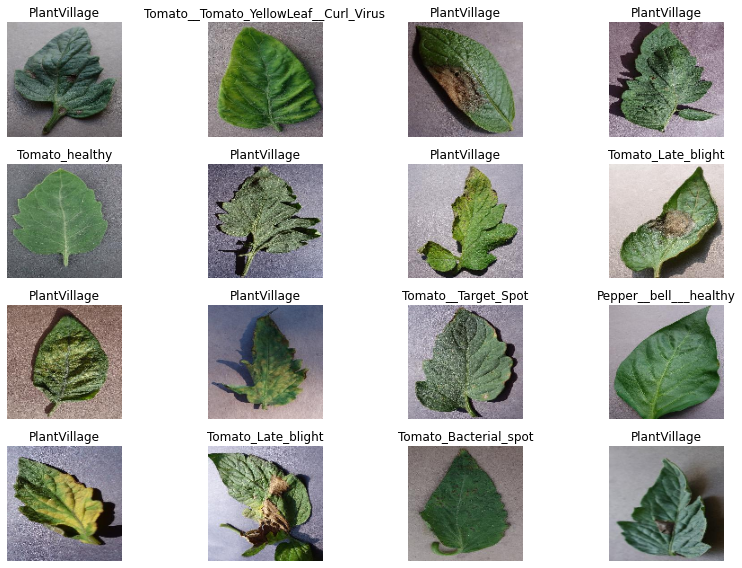

In [5]:
# Take a batch of training images
images, labels = next(train_generator)

# Get class label names
class_labels = list(train_generator.class_indices.keys())

# Plot at least 16 sample images
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


Below is a preview of sample images from the training dataset across various classes.

Observations:
- Many images are labeled as **"PlantVillage"**, which is likely an incorrect or root folder label.
- Other images show clear disease patterns like **"Tomato_YellowLeaf_Curl_Virus"**, **"Potato_Late_blight"**, etc.
- Leaf shape, color, and texture vary significantly across diseases — important for model learning.

Recommendation: Fix the dataset folder structure to remove the "PlantVillage" label and ensure each image is categorized correctly.

This visual inspection helps verify label quality and dataset readiness before training the model.

---


###  Image Dimension Consistency

Before feeding images into a CNN model, it’s important to understand the original image dimensions.

We checked a sample of images from each class to identify:
- Whether images are consistent in size
- If resizing will be necessary during preprocessing

In [ ]:
from PIL import Image
from collections import Counter

image_shapes = []

# Sample image sizes across classes
for cls in class_labels:
    folder_path = os.path.join(dataset_path, cls)
    for image_name in os.listdir(folder_path)[:10]:  # Sample 10 per class
        img_path = os.path.join(folder_path, image_name)
        try:
            with Image.open(img_path) as img:
                image_shapes.append(img.size)
        except:
            continue

# Show most common sizes
shape_counts = Counter(image_shapes)
print("Mokost common image sizes (width, height):")
for shape, count in shape_counts.most_common(5):
    print(f"{shape}: {count} images")


Most common image sizes (width, height):
(256, 256): 150 images
